In [1]:
import os
import h5py
import numpy as np
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms


class PairedHDF5Dataset(Dataset):
    def __init__(self, data_dir, 
                 groundtruth_dir):
        super(PairedHDF5Dataset, self).__init__()

        # Get a list of paths
        self.data_paths = sorted(
            [os.path.join(data_dir, file) for file in os.listdir(data_dir) if file.endswith('.hdf5')])
        self.groundtruth_paths = sorted(
            [os.path.join(groundtruth_dir, file) for file in os.listdir(groundtruth_dir) if file.endswith('.hdf5')])

        assert len(self.data_paths) == len(self.groundtruth_paths), "Mismatch between data and groundtruth files"

        # Calculate the cumulative sizes
        self.cumulative_sizes = []
        cum_size = 0
        for path in self.data_paths:
            with h5py.File(path, 'r') as file:
                cum_size += len(file['data'])
                self.cumulative_sizes.append(cum_size)
                
         # Define the image transformation to resize to half of the original size
        self.transform1 = transforms.Resize((1000 // 1, 513 // 1))
        self.transform2 = transforms.Resize((362 //1, 362 //1 ))


    def __len__(self):
        return self.cumulative_sizes[-1]

    def __getitem__(self, index):
        # Find the correct file and local index
        file_idx = next(i for i, cum_size in enumerate(self.cumulative_sizes) if cum_size > index)
        if file_idx == 0:
            local_index = index
        else:
            local_index = index - self.cumulative_sizes[file_idx - 1]

        with h5py.File(self.data_paths[file_idx], 'r') as data_file, h5py.File(self.groundtruth_paths[file_idx],
                                                                               'r') as gt_file:
            data = torch.tensor(np.expand_dims(data_file['data'][local_index], axis=0).squeeze())
            groundtruth = torch.tensor(np.expand_dims(gt_file['data'][local_index], axis=0).squeeze())
            
        
        # Resize data and groundtruth to half of the original size
        data = self.transform1(data.unsqueeze(0))
        groundtruth = self.transform2(groundtruth.unsqueeze(0))
        
        return data.squeeze(0), groundtruth.squeeze(0)


# Usage:
train_dataset = PairedHDF5Dataset(
    'observation_train',
    'ground_truth_train'
)

validation_dataset = PairedHDF5Dataset(
    'observation_validation',
    'ground_truth_validation'
)



In [2]:
from torch.utils.data import Subset
import random

# Randomly sample 200 indices from the dataset
i = random.sample(range(len(train_dataset)), 100)
j = random.sample(range(len(validation_dataset)), 20)
# Create a subset from the train_dataset using the sampled indices
subset_dataset = Subset(train_dataset, i)
valsubset_dataset = Subset(validation_dataset, j)


In [3]:
from torch.utils.data import DataLoader

data_loader = DataLoader(subset_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(valsubset_dataset, batch_size=1, shuffle=True)

Matplotlib created a temporary cache directory at /tmp/789172.tinygpu/matplotlib-c574g4pq because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


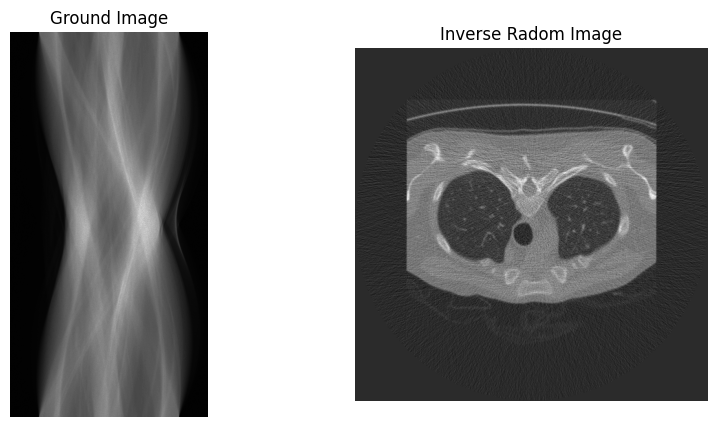

In [4]:
from skimage.transform import iradon
import matplotlib.pyplot as plt

#original_image = torch.zeros((500, 256))
for image, labels in data_loader:
    
    plt.figure(figsize=(10, 5))
    original_image = image[0]
    
    plt.subplot(1, 2, 1)
    plt.imshow(image[0], cmap='gray')
    plt.axis('off')
    plt.title('Ground Image')
    
    plt.subplot(1, 2, 2)
    iradom_image = iradon(image[0].T.numpy(), circle=True)
    plt.imshow(iradom_image, cmap='gray')
    plt.axis('off')
    plt.title('Inverse Radom Image')
    
    plt.show()
    break  

In [5]:
# 定义调整图像大小的变换
pre_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 调整大小为 ResNet50 所需的大小
    transforms.ToTensor(),           # 转换为张量
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
])

In [6]:
import torch
import torch.nn as nn
import torchvision.models as models
import os

os.environ['TORCH_HOME'] = 'directory'

class ModifiedResNet50(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedResNet50, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.resnet(x)


model = ModifiedResNet50(num_classes=362 * 362)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
model = model.cuda()

In [8]:
import torch

# 检查GPU是否可用
if torch.cuda.is_available():
    # 获取GPU设备
    device = torch.device("cuda")
    
    # 获取GPU设备的数量
    num_gpu = torch.cuda.device_count()
    
    print("Number of GPUs available:", num_gpu)
    
    for i in range(num_gpu):
        # 获取每个GPU的名称
        gpu_name = torch.cuda.get_device_name(i)
        print("GPU", i, ":", gpu_name)
        
        # 获取每个GPU的内存总量和已使用量
        total_memory = torch.cuda.get_device_properties(i).total_memory / 1024**3 # 将内存转换为GB
        allocated_memory = torch.cuda.memory_allocated(i) / 1024**3
        cached_memory = torch.cuda.memory_reserved(i) / 1024**3
        print(f"Total Memory: {total_memory:.2f} GB")
        print(f"Allocated Memory: {allocated_memory:.2f} GB")
        print(f"Cached Memory: {cached_memory:.2f} GB\n")
else:
    print("No GPU available, using CPU instead.")


Number of GPUs available: 1
GPU 0 : NVIDIA GeForce GTX 1080 Ti
Total Memory: 10.91 GB
Allocated Memory: 1.09 GB
Cached Memory: 1.12 GB



# use GV_Loss + MSE_Loss + Perceptron loss

In [9]:
def perceptron_loss(output, target):
    return torch.mean(torch.clamp(-target * output, min=0))

In [10]:
def L1_regularization(model, lambda_l1):
    l1_loss = sum(p.abs().sum() for p in model.parameters())
    return lambda_l1*l1_loss

Epoch [1/25], Train Loss: 0.0377, Val Loss: 0.0167
Epoch [2/25], Train Loss: 0.0287, Val Loss: 0.0140
Epoch [3/25], Train Loss: 0.0292, Val Loss: 0.0260
Epoch [4/25], Train Loss: 0.0286, Val Loss: 0.0138
Epoch [5/25], Train Loss: 0.0284, Val Loss: 0.0167
Epoch [6/25], Train Loss: 0.0276, Val Loss: 0.0182
Epoch [7/25], Train Loss: 0.0260, Val Loss: 0.0128
Epoch [8/25], Train Loss: 0.0238, Val Loss: 0.0131
Epoch [9/25], Train Loss: 0.0220, Val Loss: 0.0134
Epoch [10/25], Train Loss: 0.0205, Val Loss: 1034368.5906
Epoch [11/25], Train Loss: 0.0200, Val Loss: 0.0126
Epoch [12/25], Train Loss: 0.0182, Val Loss: 0.0121
Epoch [13/25], Train Loss: 0.0171, Val Loss: 0.0120
Epoch [14/25], Train Loss: 0.0163, Val Loss: 0.0121
Epoch [15/25], Train Loss: 0.0157, Val Loss: 0.0131
Epoch [16/25], Train Loss: 0.0159, Val Loss: 0.0123
Epoch [17/25], Train Loss: 0.0153, Val Loss: 0.0130
Epoch [18/25], Train Loss: 0.0150, Val Loss: 0.0124
Epoch [19/25], Train Loss: 0.0149, Val Loss: 0.0121
Epoch [20/25], 

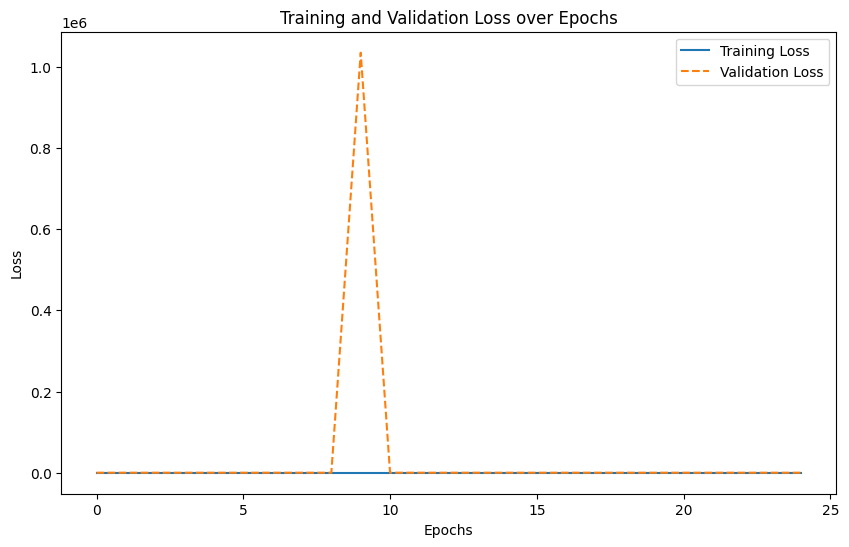

In [11]:
import matplotlib.pyplot as plt
from gradient_variance_loss import GradientVariance
import pytorch_ssim

optimizer = torch.optim.Adam(params=model.parameters(), lr=5e-7)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(data_loader), epochs=25)
criterion = nn.MSELoss()
grad_criterion = GradientVariance(patch_size = 16, cpu=False)
grad_weight = 0.02
grad_weight = torch.tensor(grad_weight).cuda()
num_epochs = 25
lambda_l1 = 5e-9


def train_model(model, data_loader, optimizer, num_epochs, val_loader=None, save_path="best_model.pth"):
    train_loss_history = []
    val_loss_history = []

    best_val_loss = float('inf')  # Initialize with a high value

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_batches = len(data_loader)

        for batch_idx, (data, groundtruth) in enumerate(data_loader):
            data = data.repeat(3,1,1)
            pil_image = transforms.ToPILImage()(data)
            data = pre_transform(pil_image)
            data, groundtruth = data.cuda(), groundtruth.cuda()
            optimizer.zero_grad()
            outputs = model(data.unsqueeze(0)).view(1, 362, 362)
            loss_mse = criterion(outputs, groundtruth)
            loss_grad = grad_weight * grad_criterion(outputs, groundtruth)
            #loss_perceptron = perceptron_loss(outputs, groundtruth)
            #ssim_loss =pytorch_ssim.SSIM(window_size = 11)
            #ssim_loss_value = ssim_loss(outputs, groundtruth).abs()
            loss = loss_grad + loss_mse
            loss += L1_regularization(model, lambda_l1)
            loss.backward(retain_graph=True)
            optimizer.step()
            running_loss += loss.item()
            scheduler.step()

        avg_train_loss = running_loss / total_batches
        train_loss_history.append(avg_train_loss)

        # Validation phase
        if val_loader:
            model.eval()
            val_running_loss = 0.0
            with torch.no_grad():
                for batch_idx,(data, groundtruth) in enumerate(val_loader):
                    data = data.repeat(3,1,1)
                    pil_image = transforms.ToPILImage()(data)
                    data = pre_transform(pil_image)
                    data, groundtruth = data.cuda(), groundtruth.cuda()
                    outputs = model(data.unsqueeze(0)).view(1, 362, 362)
                    #ssim_loss =pytorch_ssim.SSIM(window_size = 11)
                    #loss_ssim = ssim_loss(outputs, groundtruth).abs()
                    loss_mse = criterion(outputs, groundtruth)
                    loss = loss_mse
                    val_running_loss += loss.item()

            avg_val_loss = val_running_loss / len(val_loader)

            # Check if this is the best model
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                torch.save(model.state_dict(), save_path)  # Save the best model

            val_loss_history.append(avg_val_loss)
            print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        else:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

    print("Finished Training")
    return train_loss_history, val_loss_history


loss_history, val_loss_history = train_model(model, data_loader, optimizer, num_epochs, val_loader)
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()


In [12]:
def load_data_from_hdf5(filename, dataset_name="data"):
    with h5py.File(filename, 'r') as f:
        # Assuming the dataset is 3D and you want the first image
        data = f[dataset_name][-1, :, :]
    return data


phantom = load_data_from_hdf5("ground_truth_test_000.hdf5")
phantom = torch.tensor(np.expand_dims(phantom, axis=0).copy(), dtype=torch.float32).cuda()
sinogram = load_data_from_hdf5("observation_test_000.hdf5")
sinogram = torch.tensor(np.expand_dims(sinogram, axis=0).copy(), dtype=torch.float32)

In [13]:
model.eval()
sinogram = sinogram.repeat(3,1,1)
pil_sinogram = transforms.ToPILImage()(sinogram)
sinogram = pre_transform(pil_sinogram)
sinogram = sinogram.cuda()
reconstruction = model(sinogram.unsqueeze(0))

In [14]:
def normalize_image(image: np.ndarray) -> np.ndarray:
    """Normalize the pixel values of an image to the range [0, 1]."""
    min_val = image.min()
    max_val = image.max()

    return (image - min_val) / (max_val - min_val)


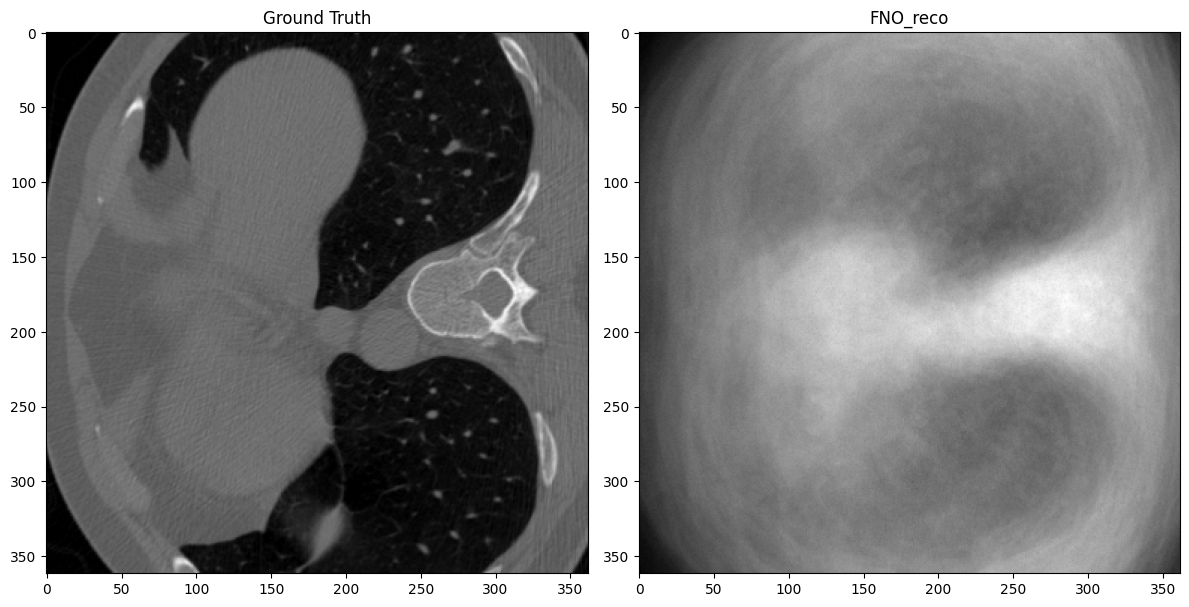

In [15]:
#reconstruction = reconstruction.detach().cpu().numpy().squeeze()
# 1. Display the original Shepp-Logan phantom.
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(normalize_image(phantom.squeeze().cpu()), cmap='gray')
plt.title('Ground Truth')

plt.subplot(1, 2, 2)
plt.imshow(normalize_image(reconstruction.view(1, 362, 362).detach().cpu().numpy().squeeze()), cmap='gray')
plt.title('FNO_reco')

plt.tight_layout()
plt.show()